# Intial setup

In [62]:
# Imports

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
from pandas import read_csv
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [5]:
# 160k+ tracks to train our model on
# https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020?select=data.csv
kaggle_spotify_dataset = read_csv('data.csv')

kaggle_spotify_dataset.sample(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
27405,0.506,['The Jimmy Castor Bunch'],0.645,222401,0.8450,0,1zFg9JAeAPnGynPGXa5jhY,0.553000,7,0.1690,-10.960,1,It's Just Begun,32,1972-03-04,0.0600,117.543,0.8610,1972
119814,0.881,['Hank Williams'],0.512,167933,0.3330,0,4tYNTVSL2alrVEFBCx4NRl,0.000002,0,0.2110,-11.685,1,Dear Brother - Single Version,17,1956-01-01,0.0301,110.689,0.3290,1956
155720,0.682,['Vince Guaraldi'],0.609,228067,0.5230,0,1MSHhgOwXXcdP2EoR6tEKW,0.943000,7,0.1200,-13.537,0,Chora Tua Tristeza,19,1963,0.0312,104.643,0.9440,1963
163305,0.575,['Los Hermanos Arriagada'],0.593,163579,0.3060,0,4gIFUzWudA3kQIDl3AhpOn,0.000000,4,0.0910,-15.163,0,Caminemos,9,1954-01-19,0.0299,101.856,0.5470,1954
153978,0.977,"['Aaron Copland', 'William Kapell']",0.534,458293,0.0648,0,2IfzKP18U3Hhzn9yIvzFPI,0.824000,6,0.0841,-18.247,1,Piano Sonata: Molto moderato,0,1945,0.0866,106.181,0.0448,1945


In [6]:
# Dimensions of the dataset (rows, cols)
kaggle_spotify_dataset.shape

(169909, 19)

In [7]:
kaggle_spotify_dataset.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,169909.000000,169909.000000,1.699090e+05,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,2.314062e+05,0.488593,0.084863,0.161937,5.200519,0.206690,-11.370289,0.708556,31.556610,0.094058,116.948017,0.532095,1977.223231
std,0.376627,0.175346,1.213219e+05,0.267390,0.278679,0.309329,3.515257,0.176796,5.666765,0.454429,21.582614,0.149937,30.726937,0.262408,25.593168
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,0.417000,1.710400e+05,0.263000,0.000000,0.000000,2.000000,0.098400,-14.470000,0.000000,12.000000,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000000,0.000204,5.000000,0.135000,-10.474000,1.000000,33.000000,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,0.667000,2.629600e+05,0.710000,0.000000,0.086800,8.000000,0.263000,-7.118000,1.000000,48.000000,0.075400,135.712000,0.749000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.969000,244.091000,1.000000,2020.000000


# Feature processing

In [8]:
# X represents the features we will use to train our model
X = kaggle_spotify_dataset[["acousticness", "danceability", "liveness", "energy", "instrumentalness", "loudness", "speechiness"]]
# All of them are in the range of [0,1] except for loudness, so we will need to rescale this feature
X.head()

,acousticness,danceability,liveness,energy,instrumentalness,loudness,speechiness
0,0.995,0.708,0.1510,0.1950,0.563,-12.428,0.0506
1,0.994,0.379,0.0763,0.0135,0.901,-28.454,0.0462
2,0.604,0.749,0.1190,0.2200,0.000,-19.924,0.9290
3,0.995,0.781,0.1110,0.1300,0.887,-14.734,0.0926
4,0.990,0.210,0.0980,0.2040,0.908,-16.829,0.0424


In [15]:
scaler = preprocessing.MinMaxScaler()
loudness = X[["loudness"]].values
# Scale the loudness feature using Min-Max normalization
loudness_scaled = scaler.fit_transform(loudness.reshape(-1, 1))
X.loc[:, "loudness"] = loudness_scaled
features = X.values

In [12]:
X.head()

,acousticness,danceability,liveness,energy,instrumentalness,loudness,speechiness
0,0.995,0.708,0.1510,0.1950,0.563,0.745000,0.0506
1,0.994,0.379,0.0763,0.0135,0.901,0.494026,0.0462
2,0.604,0.749,0.1190,0.2200,0.000,0.627609,0.9290
3,0.995,0.781,0.1110,0.1300,0.887,0.708887,0.0926
4,0.990,0.210,0.0980,0.2040,0.908,0.676079,0.0424


# Choosing a value for K (# clusters)

In [16]:
# Train a KMeans model for k=1 to k=10 clusters and keep track of the sum of squared distances for each k
sum_of_squared_distances = []
for k in range(1, 11):
    model = KMeans(n_clusters=k)
    model = model.fit(features)
    sum_of_squared_distances.append(model.inertia_)
    print(f"Model with {k} clusters trained")

Model with 1 clusters trained
Model with 2 clusters trained
Model with 3 clusters trained
Model with 4 clusters trained
Model with 5 clusters trained
Model with 6 clusters trained
Model with 7 clusters trained
Model with 8 clusters trained
Model with 9 clusters trained
Model with 10 clusters trained


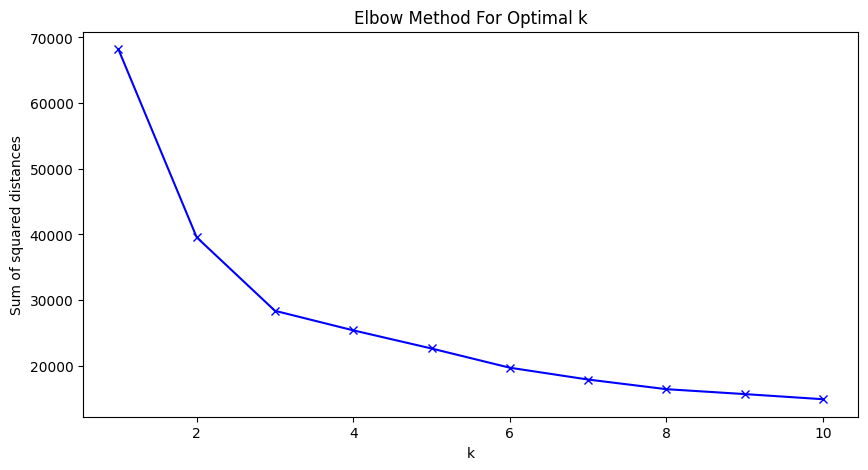

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Clustering

In [19]:
# Train the KMeans model with k=5 clusters
model = KMeans(n_clusters=5)
model = model.fit(features)

In [21]:
# Predict the cluster for each song
predictions = model.predict(features)
predictions

array([2, 2, 1, ..., 1, 3, 3])

In [23]:
kaggle_spotify_dataset['cluster'] = predictions
kaggle_spotify_dataset.sample(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,cluster
51809,0.16000,['Nazia Hassan'],0.672,321080,0.5560,0,6dxbXni1MNwzNSJ3LNYh7h,0.000226,4,0.274,-13.436,0,Boom Boom,31,1982-09-01,0.0281,129.689,0.904,1982,3
60758,0.00672,['Rancid'],0.452,148333,0.9880,0,18gBnrdlaLh0uUohNfWqlk,0.000136,0,0.404,-5.634,1,You Don't Care Nothin',37,1995-08-15,0.0722,167.980,0.673,1995,3
101072,0.72000,"['Francisco ""Charro"" Avitia']",0.374,213893,0.3610,0,6SAtOJEknkFihBbPuf5k3H,0.000005,9,0.203,-5.690,1,Corrido de Santa Amalia,32,1958-01-12,0.0361,183.286,0.611,1958,0
27522,0.64700,['Patty Pravo'],0.356,288093,0.5450,0,7n9YiIfoZwYOzvUc2jrrpp,0.000000,4,0.485,-6.334,1,Pazza idea,48,1973-01-14,0.0484,153.496,0.550,1973,1
91338,0.95300,['Vince Guaraldi Trio'],0.452,295093,0.0556,0,2eZCAJoigZpdSJY9LK3InG,0.867000,5,0.102,-24.216,0,Django,32,1956,0.0488,90.668,0.196,1956,2


# Visualization

In [32]:
pca = decomposition.PCA(n_components=2)
pca_result = pca.fit_transform(features)
df = pd.DataFrame(pca_result)
df['cluster'] = predictions
df.head()

,0,1,cluster
0,0.658976,0.114121,2
1,0.954404,0.423143,2
2,0.128846,-0.345963,1
3,0.807799,0.378912,2
4,0.858238,0.496279,2


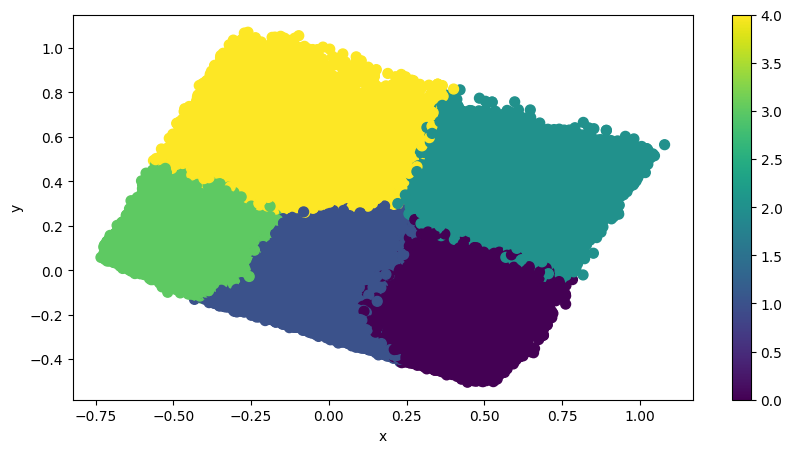

In [34]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_xlabel('x')
ax.set_ylabel('y')
scatter = ax.scatter(df[0], df[1], c=df['cluster'].values, s=50)
plt.colorbar(scatter)
plt.show()

# Training different classifier

In [35]:
df_classify = kaggle_spotify_dataset[["acousticness", "danceability", "liveness","energy", "instrumentalness", "loudness", "speechiness", "cluster"]]
X = df_classify.iloc[:, :-1].values
Y = df_classify.iloc[:, -1].values

In [37]:
# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [41]:
# Scale the 5th feature (loudness) using Min-Max normalization
X_train[:, 5] = scaler.fit_transform(X_train[:, 5].reshape(-1, 1)).reshape(-1)
X_test[:, 5] = scaler.transform(X_test[:, 5].reshape(-1, 1)).reshape(-1)

In [42]:
# Train a KNN classifier for k=2 to k=9 neighbors and keep track of the accuracy for each k
acc=[]
for i in range(2,10):
  classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
  classifier.fit(X_train, Y_train)
  Y_pred = classifier.predict(X_test)
  acc.append(accuracy_score(Y_test, Y_pred))
  print(f'{i}:{acc[-1]}')

2:0.9743393561297158
3:0.980666235065623
4:0.9798422694367607
5:0.9827850038255547
6:0.9820493202283562
7:0.9838149608616327
8:0.9839326702371843
9:0.9844917897710552


In [46]:
# Train a Random Forest classifier for n=5 to n=13 trees and keep track of the accuracy for each n
acc=[]
for i in range(5,14):
  classifier = RandomForestClassifier(n_estimators = i, criterion = 'entropy', random_state = 0)
  classifier.fit(X_train, Y_train)
  Y_pred = classifier.predict(X_test)
  acc.append(accuracy_score(Y_test, Y_pred))
  print(f'{i}:{acc[-1]}')

5:0.9860808663410041
6:0.9858454475899006
7:0.9871402507209699
8:0.987081396033194
9:0.988081925725384
10:0.9877876522865047
11:0.9884644811959272
12:0.9887293272909187
13:0.9892295921370137


In [49]:
# Train a Naive Bayes classifier
acc=[]

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
acc.append(accuracy_score(Y_test, Y_pred))
print(f'{i}:{acc[-1]}')

13:0.9333470660938143


In [51]:
# Train a SVM classifier for each kernel and keep track of the accuracy for each kernel
acc=[]
for i in ['linear', 'poly', 'rbf', 'sigmoid']:
  classifier = SVC(kernel = i, random_state = 0)
  classifier.fit(X_train, Y_train)
  Y_pred = classifier.predict(X_test)
  acc.append(accuracy_score(Y_test, Y_pred))
  print(f'{i}:{acc[-1]}')

linear:0.9975869578011889
poly:0.9974692484256371
rbf:0.9971749749867577
sigmoid:0.6243599552704373


In [52]:
classifier = SVC(kernel ='poly', random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

In [53]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[ 8775    10     5     0     0]
 [   10  7435     1    22     2]
 [    2     0  4518     0     5]
 [    0    16     0 11681     5]
 [    0     3     2     3  1487]]


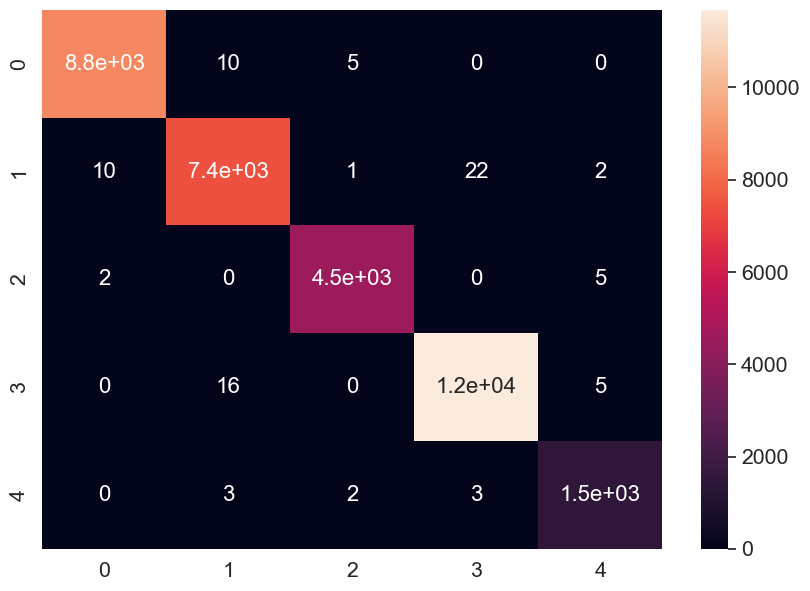

In [56]:
df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize=(10,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()

# Cluster description

In [61]:
df = kaggle_spotify_dataset[["id","acousticness", "danceability", "liveness","energy", "instrumentalness", "loudness", "speechiness", "cluster"]]

cluster_info = []
for i in range(5):
  cluster_info.append(df[df['cluster'] == i].describe().iloc[1,:])

cluster_info

[acousticness         0.878883
 danceability         0.489093
 liveness             0.208687
 energy               0.259463
 instrumentalness     0.037162
 loudness           -14.020297
 speechiness          0.086344
 cluster              0.000000
 Name: mean, dtype: float64,
 acousticness         0.473721
 danceability         0.602656
 liveness             0.208551
 energy               0.493430
 instrumentalness     0.015160
 loudness           -10.754410
 speechiness          0.140079
 cluster              1.000000
 Name: mean, dtype: float64,
 acousticness         0.929106
 danceability         0.418680
 liveness             0.178713
 energy               0.225010
 instrumentalness     0.819364
 loudness           -17.896771
 speechiness          0.060241
 cluster              2.000000
 Name: mean, dtype: float64,
 acousticness        0.086389
 danceability        0.586584
 liveness            0.212100
 energy              0.737803
 instrumentalness    0.017393
 loudness          

# Classifying my liked songs

In [63]:
with open('config.json') as f:
    config = json.load(f)

cid = config['cid']
secret = config['secret']
username = config['username']

In [64]:
# Avaliable scopes: https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private user-top-read playlist-modify-private user-read-currently-playing'
redirect_uri='https://example.com/callback'
client_credentials_manager = spotipy.oauth2.SpotifyOAuth(scope=scope, username=username,client_id=cid, client_secret=secret, redirect_uri=redirect_uri, cache_path='./tokens.txt') 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [76]:
offset = 0
songs = []
names = []
ids = []

# Retrieve my liked songs in batches of 50 until all songs are fetched
while True:
    # Fetch tracks from Spotify API
    content = sp.current_user_saved_tracks(limit=50, offset=offset)
    songs += content['items']

    # If there are more tracks to fetch, increase the offset
    if content['next'] is not None:
        offset += 50
    else:
        break

# Extract the name and id of each song
for i in songs:
    names.append(i['track']['name'])
    ids.append(i['track']['id'])

index=0
audio_features=[]

# Retrieve the audio features of my liked songs in batches of 50
while index < len(ids):
    # Fetch audio features from Spotify API
    audio_features += sp.audio_features(ids[index:index + 50])
    index += 50

# Create a list of lists with the audio features of each song
features_list = []
for features in audio_features:
    features_list.append([features['acousticness'], features['danceability'], features['liveness'], features['energy'], features['instrumentalness'], features['loudness'], features['speechiness']])

# Create a dataframe from the list of audio features with track IDs as index
mydf = pd.DataFrame(features_list, columns=["acousticness", "danceability", "liveness","energy", "instrumentalness", "loudness", "speechiness"],index=ids)

In [77]:
# Sanity check
len(songs)

2182

In [78]:
mydf.head()

,acousticness,danceability,liveness,energy,instrumentalness,loudness,speechiness
0JiY190vktuhSGN6aqJdrt,0.000334,0.534,0.241,0.870,0.000000,-3.078,0.0425
1QV6tiMFM6fSOKOGLMHYYg,0.118000,0.851,0.121,0.806,0.000002,-4.620,0.0787
2ygMBIctKIAfbEBcT9065L,0.009370,0.648,0.752,0.931,0.000000,-3.150,0.1810
4wH4dJgrsxONID6KS2tDQM,0.026100,0.796,0.121,0.777,0.000358,-4.810,0.0397
6I9VzXrHxO9rA9A5euc8Ak,0.024900,0.774,0.242,0.838,0.025000,-3.914,0.1140


In [79]:
loudness=mydf['loudness'].values
loudness_scaled=scaler.fit_transform(loudness.reshape(-1,1))
mydf['loudness'] = loudness_scaled

features = mydf.values
predictions = classifier.predict(features)
mydf['cluster'] = predictions
mydf.head()

,acousticness,danceability,liveness,energy,instrumentalness,loudness,speechiness,cluster
0JiY190vktuhSGN6aqJdrt,0.000334,0.534,0.241,0.870,0.000000,0.928741,0.0425,3
1QV6tiMFM6fSOKOGLMHYYg,0.118000,0.851,0.121,0.806,0.000002,0.886053,0.0787,3
2ygMBIctKIAfbEBcT9065L,0.009370,0.648,0.752,0.931,0.000000,0.926748,0.1810,3
4wH4dJgrsxONID6KS2tDQM,0.026100,0.796,0.121,0.777,0.000358,0.880793,0.0397,3
6I9VzXrHxO9rA9A5euc8Ak,0.024900,0.774,0.242,0.838,0.025000,0.905598,0.1140,3


In [80]:
mydf.shape

(2182, 8)

In [83]:
# Combine the index (track IDs) and the cluster predictions into a list of tuples
clustered_songs = list(zip(mydf.index,mydf.iloc[:,-1]))

# Sort the songs into lists based on their cluster
sorted_songs=[[],[],[],[],[]]
for i in range(len(clustered_songs)):
    sorted_songs[clustered_songs[i][1]].append(clustered_songs[i][0])

In [84]:
# Sanity check
print(len(sorted_songs[0]))
print(len(sorted_songs[1]))
print(len(sorted_songs[2]))
print(len(sorted_songs[3]))
print(len(sorted_songs[4]))

204
502
21
1372
83


In [86]:
# Create 5 playlists with the sorted songs
playlist_names = ['🐸','🪐','🦊','🐳','🦜']
playlists = []
for i in range(5):
    # Create a playlist for each cluster
    playlist_created = sp.user_playlist_create(username, name=playlist_names[i], public=False,description='')
    for j in range(0, len(sorted_songs[i]), 100):
        # Add songs to the playlist in batches of 100
        sp.user_playlist_add_tracks(username,playlist_created['id'],sorted_songs[i][j:j + 100])
        playlists.append(playlist_created)

In [87]:
# Count the number of songs in each cluster
len_clusters = []
for i in range(5):
    len_clusters.append(len(mydf[mydf['cluster']==i].values))

print('my saved songs:')

# Calculate the percentage of songs in each cluster
pers = []
for i in range(5):
    pers.append(float(len_clusters[i]/sum(len_clusters)))
    print(i,float(len_clusters[i]/sum(len_clusters)))

my saved songs:
0 0.09349220898258478
1 0.23006416131989002
2 0.009624197983501375
3 0.6287809349220899
4 0.038038496791934


# Sources

https://github.com/chingisooinar/Clustering-my-songs-on-Spotify/blob/main/Clustering_my_songs_on_Spotify.ipynb

https://towardsdatascience.com/cluster-your-liked-songs-on-spotify-into-playlists-of-similar-songs-66a244ba297e